tutorial + code is available at

https://towardsdatascience.com/machine-learning-text-classification-language-modelling-using-fast-ai-b1b334f2872d

and

https://docs.fast.ai/text.html

In [1]:
from fastai.text import * 

# Read in the data

In [2]:
path = untar_data(URLs.IMDB_SAMPLE)
path

WindowsPath('C:/Users/lpott/.fastai/data/imdb_sample')

In [3]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'))

In [4]:
df = pd.DataFrame(data={"label":newsgroups_train["target"],"sentence":newsgroups_train["data"]})
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.head()

Number of training sentences: 18,846



,label,sentence
0,10,\n\nI am sure some bashers of Pens fans are pr...
1,3,My brother is in the market for a high-perform...
2,17,\n\n\n\n\tFinally you said what you dream abou...
3,3,\nThink!\n\nIt's the SCSI card doing the DMA t...
4,4,1) I have an old Jasmine drive which I cann...


# Split the data

In [5]:
from sklearn.model_selection import train_test_split
# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(df['sentence'], df['label'], 
                                                            random_state=2018, test_size=0.22)

In [6]:
col_names = ['labels','text']
df_trn = pd.DataFrame({'text':train_inputs, 'labels':train_labels}, columns=col_names)
df_val = pd.DataFrame({'text':validation_inputs, 'labels':validation_labels}, columns=col_names)

# Data Preprocessing

* xxbos: Begining of a sentence
* xxfld: Represent separate parts of a document like title, summary etc., each one will get a separate field and so they will get numbered (e.g. xxfld 1, xxfld 2).
* xxup: If there's something in all caps, it gets lower cased and a token called xxup will get added to it. Words that are fully capitalized, such as “I AM SHOUTING”, are tokenized as “xxup i xxup am xxup shouting“
* xxunk: token used instead of an uncommon word.
* xxmaj: token indicates that there is capitalization of the word. “The” will be tokenized as “xxmaj the“.
* xxrep: token indicates repeated word, if you have 29 ! in a row, (i.e. xxrep 29 !).

In [7]:
# Language model data
defaults.cpus=1
data_lm = TextLMDataBunch.from_df(path=path, train_df=df_trn, valid_df=df_val,bs=16)

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\fastai\core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [8]:
data_lm.show_batch()

idx,text
0,xxmaj vida > number of flying hours -- what are these limits ? xxmaj what are the \n xxmaj vida > main problems associated with too many long - haul ( over 4 hours ) \n xxmaj vida > trips ? \n \n xxmaj the crew rest requirements are to prevent undue fatigue . xxmaj the cockpit \n crew ( pilot ) limits are somewhat more
1,"gregory of xxmaj nazianzus , among others . xxmaj while starting with three , \n they show that their unity in nature and and action is such that one \n must think of them as being a single xxmaj god . xxmaj this allowed the xxmaj council \n of xxmaj constantinople , in 381 , to get wide agreement on the idea of \n three xxunk"
2,\n xxup db xxup 10111000b ; 10111000 \n xxup db xxup 10111001b ; 10111001 \n xxup db xxup 10111010b ; 10111010 \n xxup db xxup 10111011b ; 10111011 \n xxup db xxup 10110011b ; 10 xxrep 4 1 00 \n xxup db 10 xxrep 4 1 xxup 01b ; 10 xxrep 4 1 01 \n xxup db 10 xxrep 5 1 xxup 0b
3,grb 's in the xxmaj oort cloud just came \n through the astrophysics abstract service . xxmaj to get a copy of this \n \n xxmaj here is the abstract of that paper . \n \n ... \n indicator to these events all possible sources which are \n isotropically distributed should remain under consideration . xxmaj this is \n why the xxmaj oort cloud
4,"and shouders in xxup ttddd format ! xxmaj check it \n out , only if you ca n't use xxup ftp ! -- nfotis ] \n \n xxup inria - xxup graphlib \n xxrep 14 - \n xxmaj pierre xxmaj jancene and xxmaj sabine xxmaj coquillart launched the inria - graphlib mail \n server a few months ago . \n \n echo help |"


In [9]:
# save and load
# data_lm.save('tmp_lm.pkl')
# data_lm = TextClasDataBunch.load(path, 'tmp_lm.pkl')

## Language model fine-tuning

In [10]:
# Language model
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


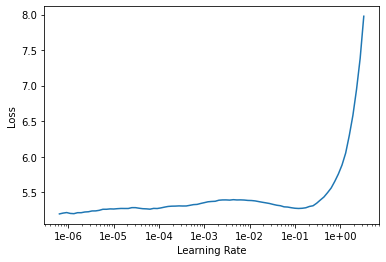

In [12]:
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.171605,4.248922,0.270208,7:52:16
1,4.571016,4.269239,0.270541,05:46
2,4.519972,4.207200,0.277460,05:50
3,4.400272,4.151412,0.284316,05:54
4,4.190954,4.131828,0.286845,05:54


In [14]:
torch.cuda.empty_cache()

In [15]:
learn.unfreeze()
learn.fit_one_cycle(5,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.881052,3.943559,0.314509,06:50
1,3.796178,3.887884,0.331811,06:52
2,3.588528,3.782378,0.346147,06:57
3,3.538262,3.720194,0.356086,06:56
4,3.227068,3.717727,0.357836,06:53


In [16]:
learn.predict("This computer is ",n_words=15)

'This computer is  a pretty reliable designed hot hat . This is bureau \n  of the %'

In [17]:
learn.save_encoder('fine_enc')

In [18]:
(torch.cuda.memory_cached()-torch.cuda.memory_allocated())*10**-6

1267.570688

In [19]:
torch.cuda.memory_allocated()*10**-6

863.1357439999999

In [20]:
torch.cuda.empty_cache()

In [21]:
(torch.cuda.memory_cached()-torch.cuda.memory_allocated())*10**-6

321.755136

In [22]:
torch.cuda.memory_allocated()*10**-6

863.1357439999999

# Creating the classifier

In [23]:
defaults.cpus=1
data_clas = TextClasDataBunch.from_df(path,train_df=df_trn,valid_df=df_val,
                                      vocab=data_lm.train_ds.vocab,bs=8)

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\fastai\core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [24]:
torch.cuda.empty_cache()

In [25]:
classifier = text_classifier_learner(data_clas,AWD_LSTM,drop_mult=0.45)

In [26]:
classifier.load_encoder('fine_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (14699 items)
x: TextList
xxbos xxmaj umm , perhaps you could explain what ' rights ' we are talking about 
  here ..,xxbos ... 
 
  xxmaj apologies , i 've not been paying attention .,xxbos 
  xxmaj vida > xxmaj can one develop inner - ear problems from too much flying ? i hear 
  xxmaj vida > that pilots and steward / esses have a limit as to the maximum 
  xxmaj vida > number of flying hours -- what are these limits ? xxmaj what are the 
  xxmaj vida > main problems associated with too many long - haul ( over 4 hours ) 
  xxmaj vida > trips ? 
 
  xxmaj the crew rest requirements are to prevent undue fatigue . xxmaj the cockpit 
  crew ( pilot ) limits are somewhat more stringent than the cabin crew 
  limits for this reason . xxmaj crew rest requirements address amount of time 
  on duty plus rest time . a tired crew is an accident - prone crew . 
 
  xxmaj the only limits i know of for inner - ear problems are in military 
  air

In [27]:
classifier.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


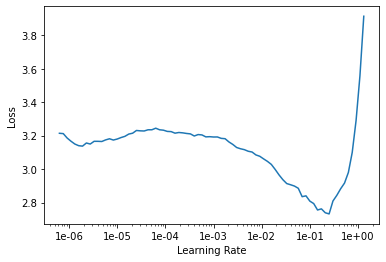

In [28]:
classifier.recorder.plot()

In [29]:
classifier.fit_one_cycle(5,1e-2,moms=(.8,.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.603031,1.395800,0.599228,05:23
1,1.408494,1.658821,0.637087,05:51
2,1.271786,1.125516,0.659513,05:50
3,1.307052,1.099240,0.672052,05:34
4,1.146087,1.191055,0.685315,05:27


C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

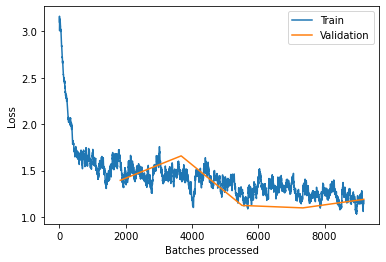

In [30]:
classifier.recorder.plot_losses()

In [31]:
torch.cuda.empty_cache()

In [32]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(5,slice(5e-3/2.,5e-3),moms=(.8,.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.321372,1.132720,0.659995,06:06
1,1.225484,1.087431,0.667953,05:55
2,1.235199,1.059170,0.687485,06:28
3,0.952904,0.978201,0.701712,06:48
4,0.797240,0.956100,0.712322,06:25


C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

In [33]:
torch.cuda.empty_cache()

In [34]:
classifier.unfreeze()
classifier.fit_one_cycle(5,slice(1e-3/100,1e-3),moms=(.8,.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.749052,0.969389,0.713769,09:27
1,0.707079,0.982585,0.712563,10:14
2,0.710691,0.981648,0.721244,09:03
3,0.605620,0.983015,0.722209,09:28
4,0.605049,0.997659,0.716180,08:38


C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

In [35]:
torch.cuda.empty_cache()

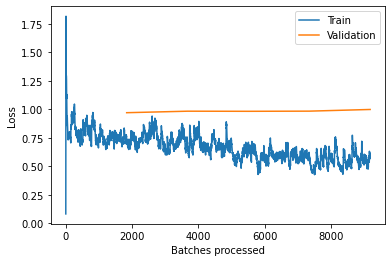

In [36]:
classifier.recorder.plot_losses()

In [87]:
for i,group in enumerate(newsgroups_train.target_names):
    print(i,group)

0 alt.atheism
1 comp.graphics
2 comp.os.ms-windows.misc
3 comp.sys.ibm.pc.hardware
4 comp.sys.mac.hardware
5 comp.windows.x
6 misc.forsale
7 rec.autos
8 rec.motorcycles
9 rec.sport.baseball
10 rec.sport.hockey
11 sci.crypt
12 sci.electronics
13 sci.med
14 sci.space
15 soc.religion.christian
16 talk.politics.guns
17 talk.politics.mideast
18 talk.politics.misc
19 talk.religion.misc


In [89]:
classifier.predict("My laptop seemed to have a virus on it, but apple genius said they would fix it")

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(4),
 tensor(4),
 tensor([3.5127e-04, 6.3302e-03, 6.6285e-03, 5.1927e-02, 8.6459e-01, 2.4295e-02,
         6.4170e-04, 1.5732e-03, 3.0166e-04, 2.7922e-02, 1.1639e-03, 3.0501e-03,
         9.8098e-03, 4.3994e-04, 2.4304e-05, 2.9395e-04, 2.9358e-04, 2.5966e-04,
         1.4776e-05, 9.0718e-05]))